In [23]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
train_data_path = "C:\\Users\\tkdwl\\Aiffel\\node10\\data\\train.csv"
sub_data_path = "C:\\Users\\tkdwl\\Aiffel\\node10\\data\\test.csv"

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [25]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


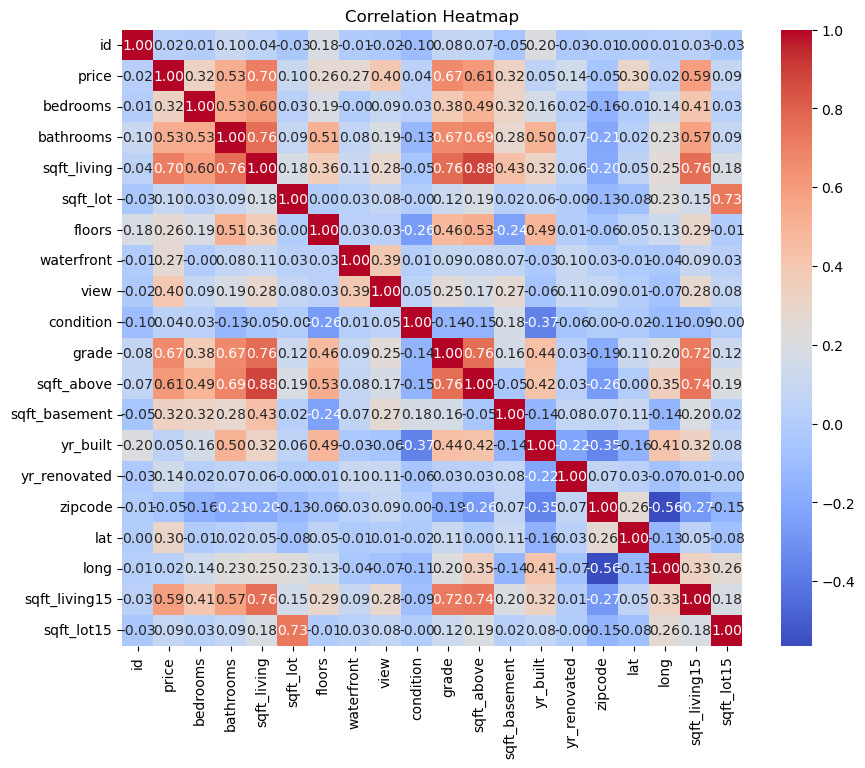

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
zipcode         -0.051498
Name: price, dtype: float64


In [26]:
import matplotlib.pyplot as plt

corr = data.corr(numeric_only=True)   # 숫자형만 상관관계 계산
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

print(corr["price"].sort_values(ascending=False))

In [27]:
y = data['price']

del data['price']

In [ ]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

# drop할 feature 목록
drop_features = ["yr_renovated",
"sqft_lot",
"sqft_lot15",
"yr_built",
"condition",
"long",
"id",
"zipcode"]

# 데이터에서 제거
data = data.drop(columns=drop_features)

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [29]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

print(data.columns)
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
print(vif_data)

Index(['date', 'bathrooms', 'sqft_living', 'grade', 'sqft_above',
       'sqft_living15'],
      dtype='object')
         feature         VIF
0           date   64.385358
1      bathrooms   20.930414
2    sqft_living   37.221907
3          grade  128.195753
4     sqft_above   27.151773
5  sqft_living15   25.169822


In [31]:
data.shape

(21503, 6)

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

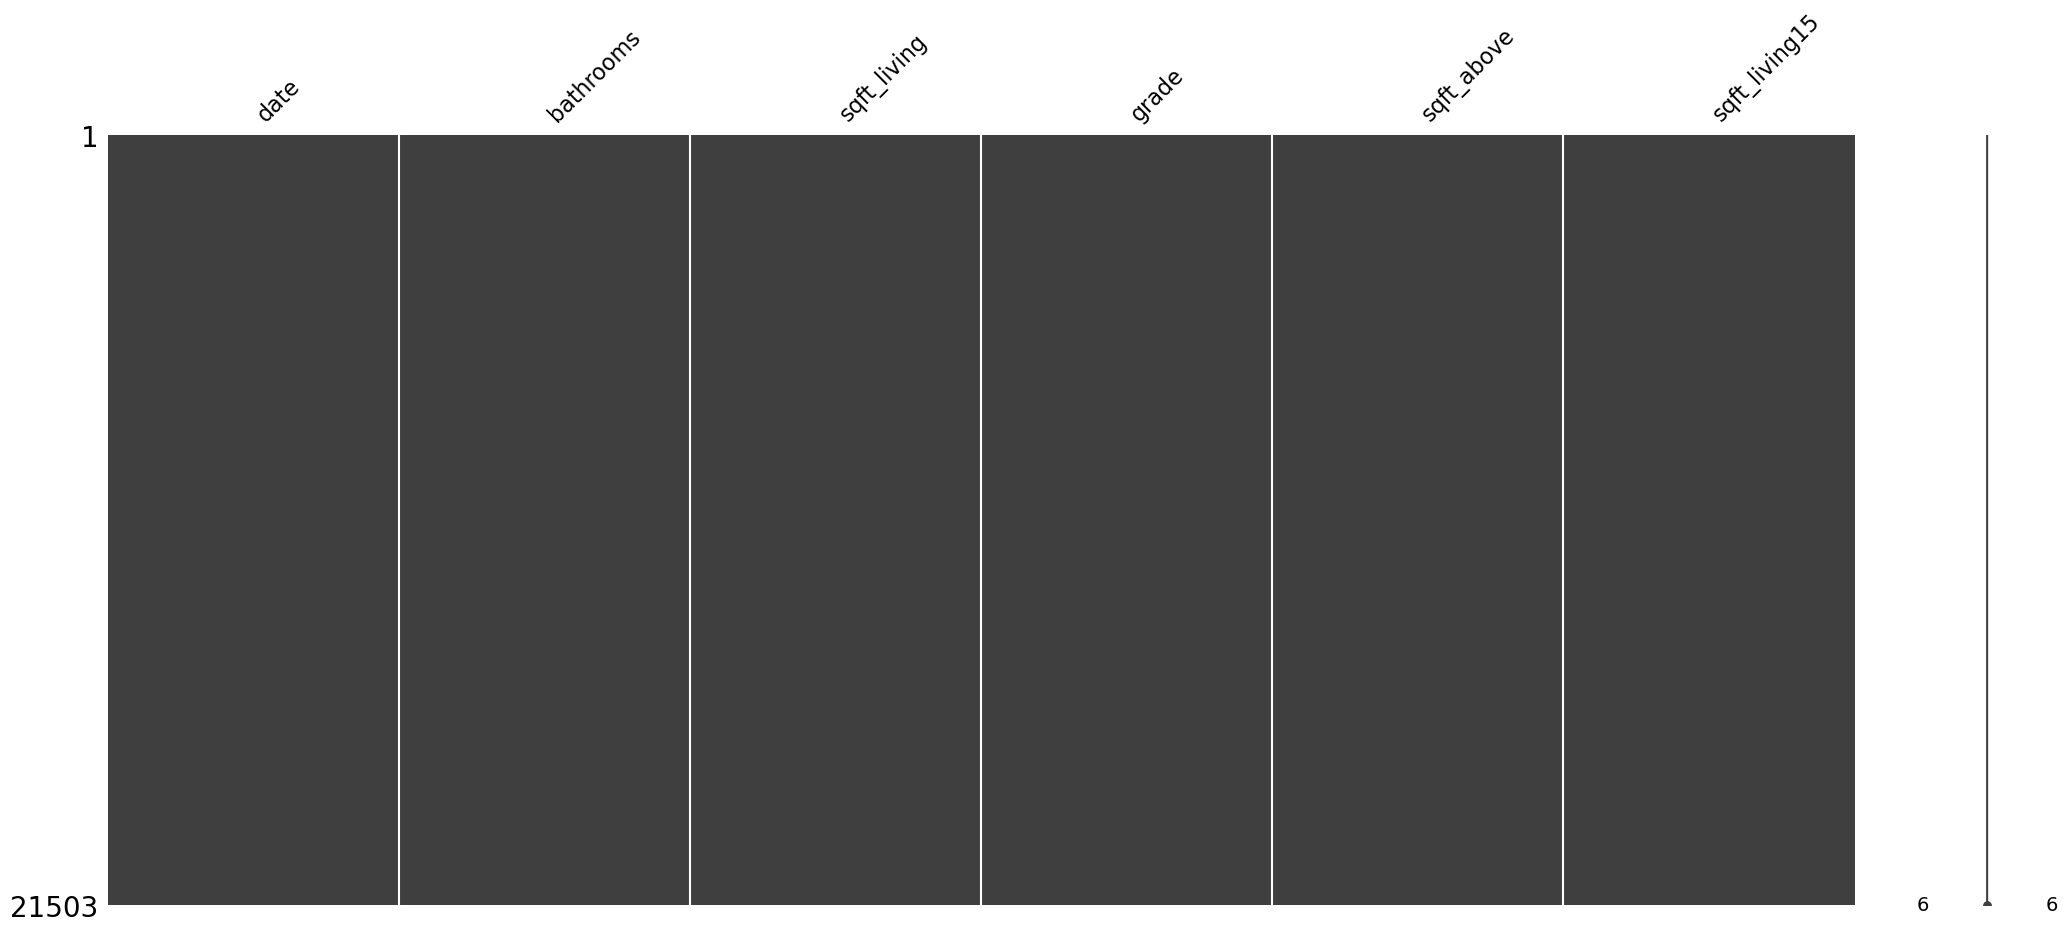

In [32]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [33]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bathrooms : 0
sqft_living : 0
grade : 0
sqft_above : 0
sqft_living15 : 0


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

IndexError: index 6 is out of bounds for axis 0 with size 6

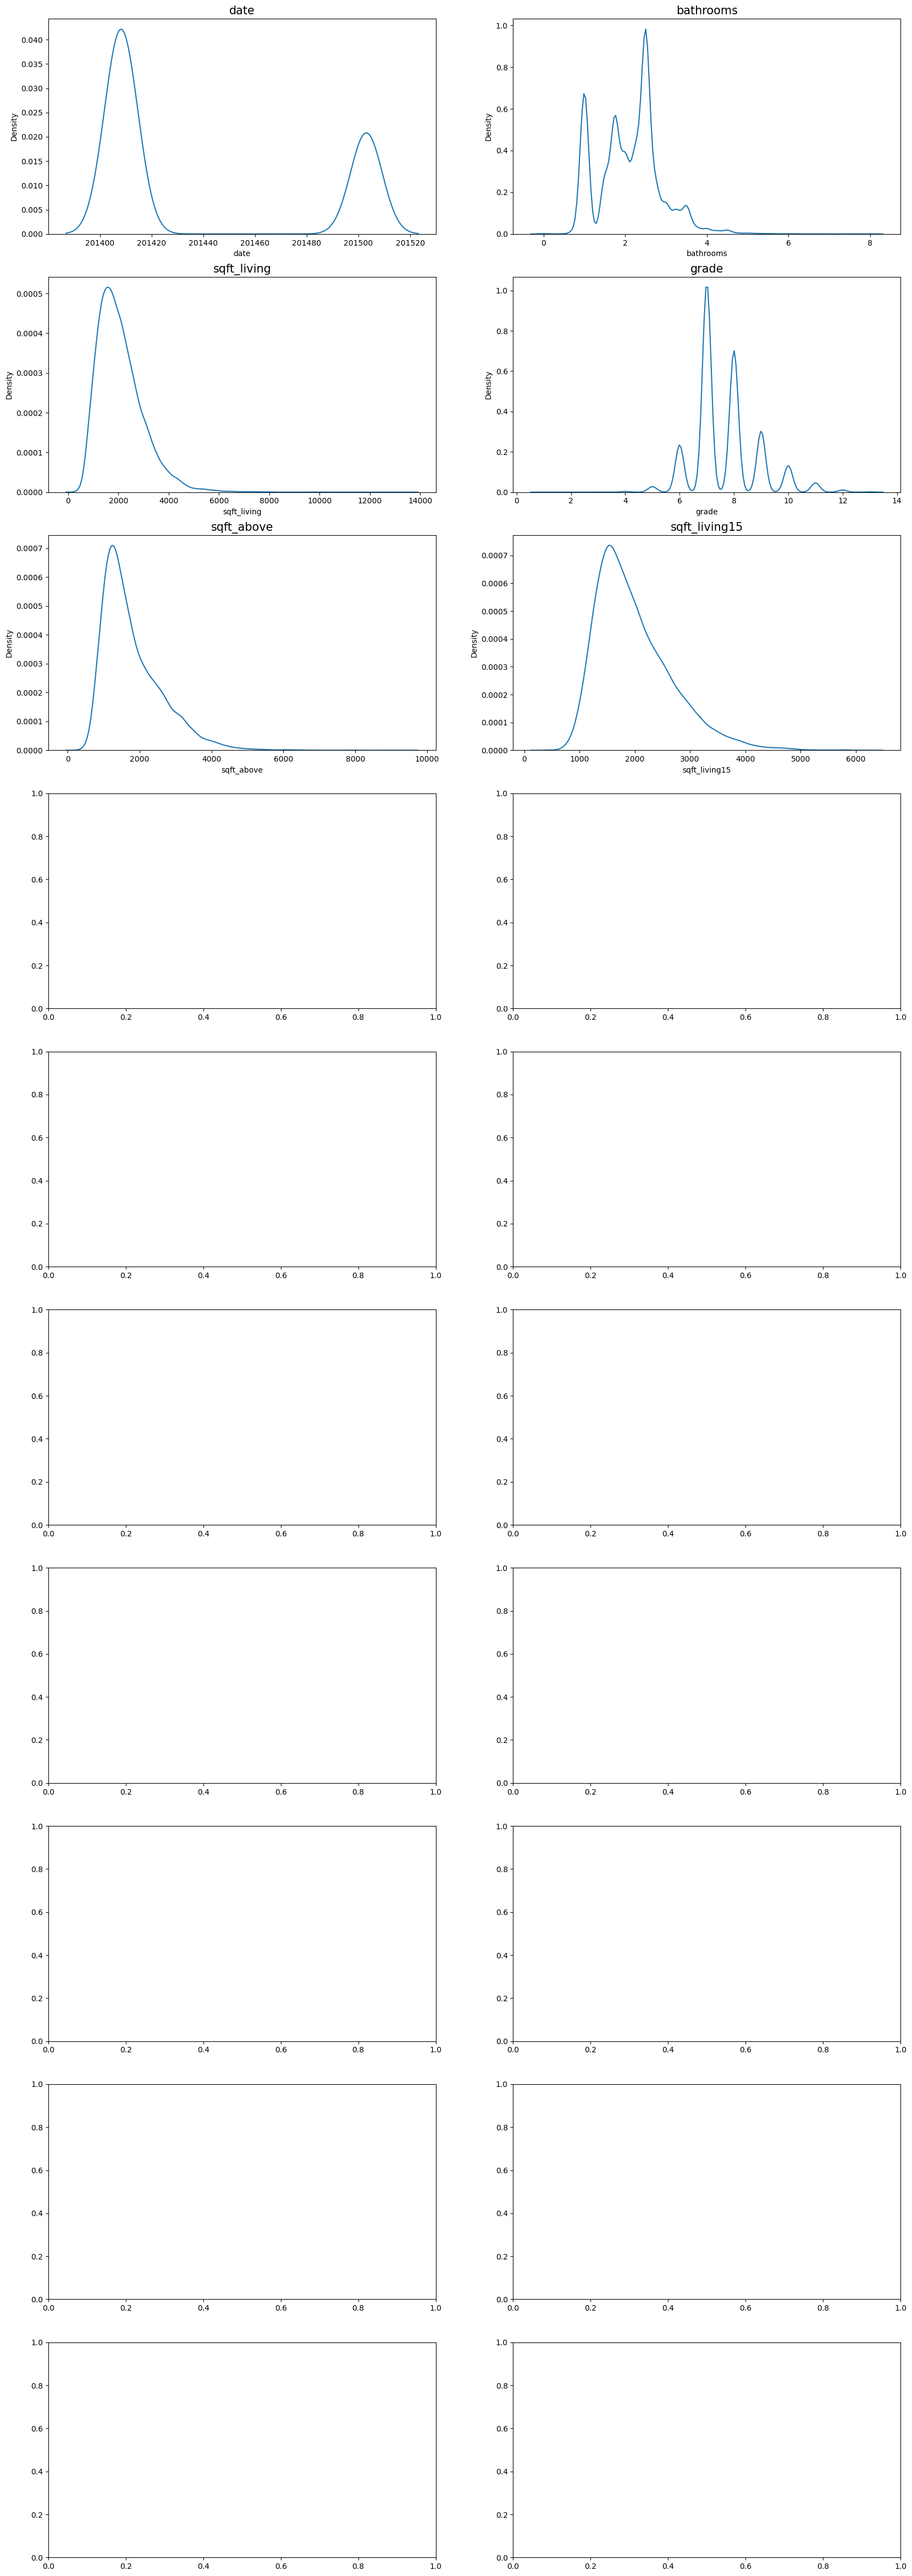

In [34]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

NameError: name 'skew_columns' is not defined

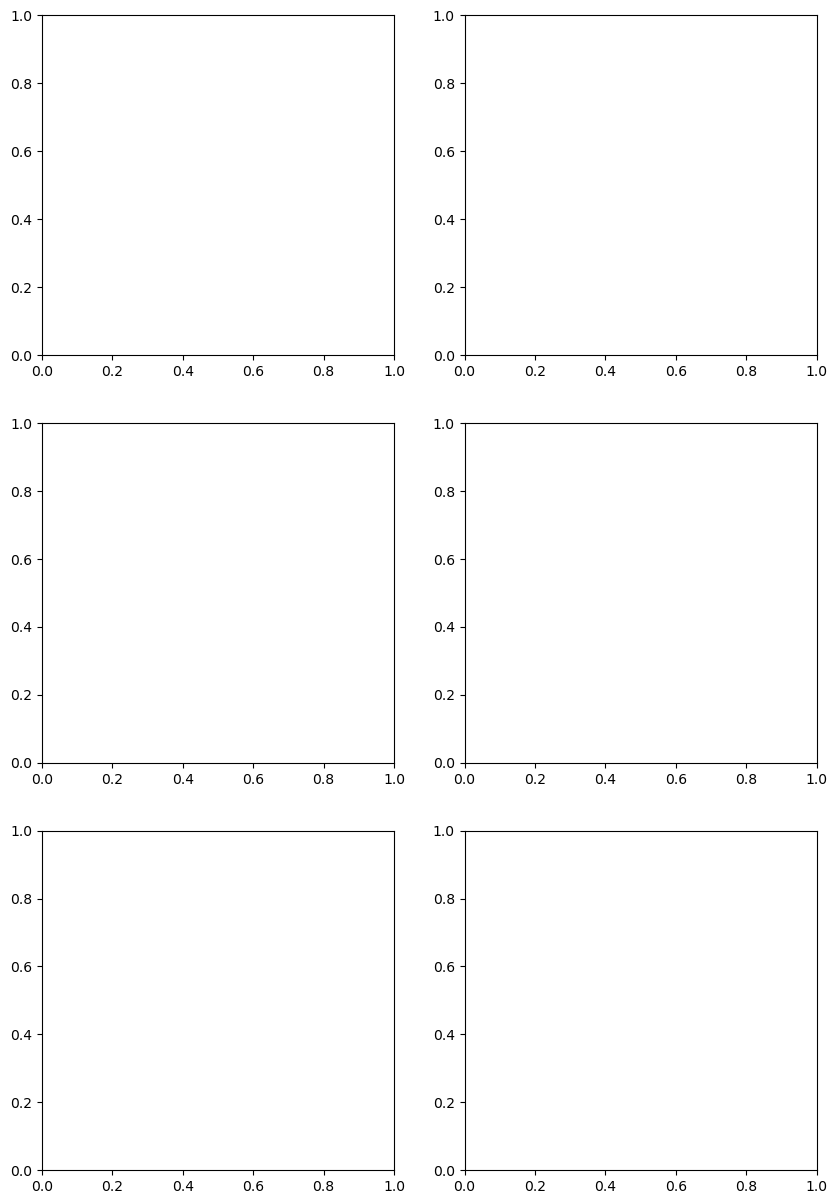

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [35]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [36]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [37]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [38]:
get_cv_score(models)

Model GradientBoosting CV score : 0.6000
Model XGBoost CV score : 0.5601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 6
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 6
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [39]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [40]:
y_pred = AveragingBlending(models, x, y, sub)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 6
[LightGBM] [Info] Start training from score 540682.653143


In [41]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [42]:
sub.to_csv('submission.csv', index=False)